Pizza image downloaded successfully.
Salad image downloaded successfully.
Hamburger image downloaded successfully.
Sushi image downloaded successfully.
Apple image downloaded successfully.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 1.9931
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 1.0000 - loss: 0.0482
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 1.0000 - loss: 3.7590e-04
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 8.2248e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Food: Pizza, Estimated Calories: 266


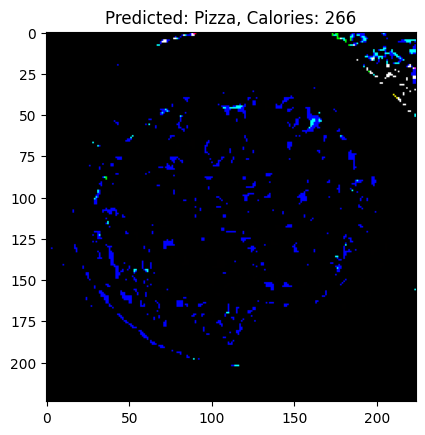

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Food: Salad, Estimated Calories: 150


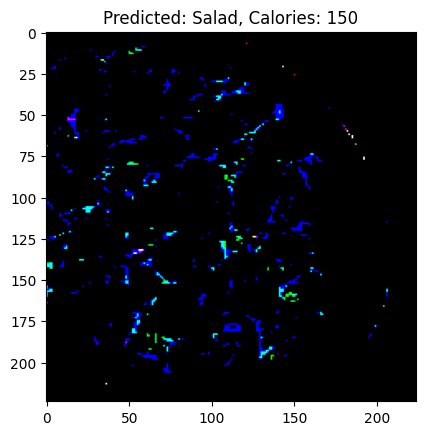

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Food: Hamburger, Estimated Calories: 295


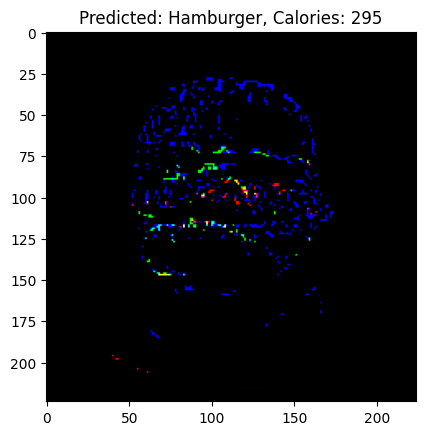

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted Food: Sushi, Estimated Calories: 200


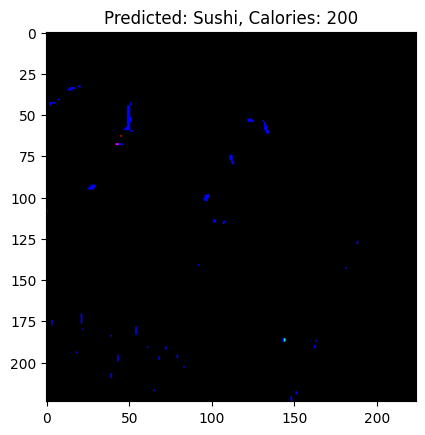

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicted Food: Apple, Estimated Calories: 52


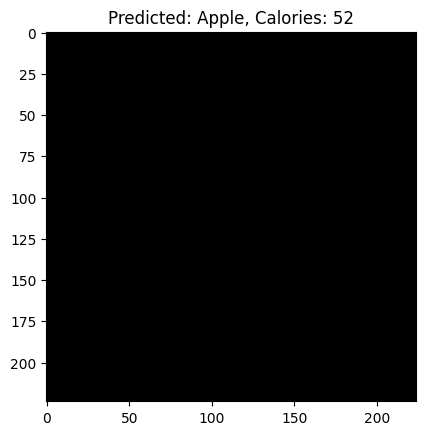

In [1]:
import numpy as np
import tensorflow as tf
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Create a directory to save the images
if not os.path.exists('food_images'):
    os.makedirs('food_images')

# List of food items to scrape
food_items = ['pizza', 'salad', 'hamburger', 'sushi', 'apple']

# Function to scrape and download images
def download_food_images(food_item, num_images=1):
    url = f"https://www.google.com/search?q={food_item}&tbm=isch"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    images = soup.find_all('img')
    count = 0

    for img in images:
        if count >= num_images:
            break

        img_url = img['src']
        try:
            img_data = requests.get(img_url).content
            img_name = f"food_images/{food_item}.jpg"
            with open(img_name, 'wb') as handler:
                handler.write(img_data)
            print(f"{food_item.capitalize()} image downloaded successfully.")
            count += 1
        except:
            continue

# Download 1 image per food item
for food in food_items:
    download_food_images(food)


def load_and_preprocess_image(image_path, img_size=(224, 224)):
    img = Image.open(image_path).convert('RGB') # Ensure all images are RGB
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
    return img_array

# Ensure 'food_items' is defined
image_paths = [f"food_images/{food}.jpg" for food in food_items]

# Corresponding labels and calories for the images
labels = ["Pizza", "Salad", "Hamburger", "Sushi", "Apple"]
calories = {"Pizza": 266, "Salad": 150, "Hamburger": 295, "Sushi": 200, "Apple": 52}

# Load images and labels
images = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])

# Convert labels to one-hot encoding
label_indices = np.arange(len(labels))
y_train = label_indices  # Using indices directly for simplicity


# Load pre-trained MobileNetV2 model + higher layers for fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer for classification

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers (optional, depending on dataset size)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on your 5 images
model.fit(images, y_train, epochs=5)


# Predict and estimate calories
def predict_and_estimate_calories(image):
    img_array = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_label_index = np.argmax(predictions)
    predicted_label = labels[predicted_label_index]
    predicted_calories = calories[predicted_label]
    return predicted_label, predicted_calories

for i in range(0,5):
    test_image = images[i]
    predicted_label, predicted_calories = predict_and_estimate_calories(test_image)
    print(f"Predicted Food: {predicted_label}, Estimated Calories: {predicted_calories}")
    plt.imshow(images[i].astype(np.uint8))
    plt.title(f"Predicted: {predicted_label}, Calories: {predicted_calories}")
    plt.show()
